In [2]:
import numpy as np
import math
import csv
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ngs_toolkit.graphics import add_colorbar_to_axis, savefig

In [67]:
def load_data(path):
    df = pd.read_csv(path)
    # filter by baseMean
    df = df[df["baseMean"] > 15]
    # filter by NA in padj
    df = df.dropna(subset=['log2FoldChange', 'padj'])
    
    return (df["log2FoldChange"].tolist(), -np.log10(df["padj"].tolist()))

/home/elizabeth/miniconda3/envs/work_saskia/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


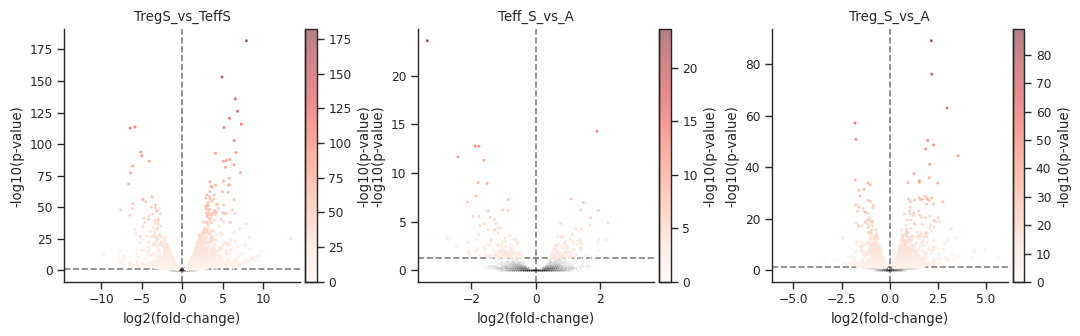

In [82]:
paths = [
    r"../../data/deg/TregS_vs_TeffS.csv",
    r"../../data/deg/Teff_S_vs_A.csv",
    r"../../data/deg/Treg_S_vs_A.csv",
]

datapoints = []

for path in paths:
    datapoints.append(load_data(path))

create_volcano_plots_general(datapoints, 
                             names=("TregS_vs_TeffS","Teff_S_vs_A","Treg_S_vs_A"),
                             global_max=False,
                             save_path=r"../../results/rna_volcanos_ngs.pdf")

In [81]:
#def create_volcano_plots(groups, p_cutoff=0.05):
#    # Code from ngs_toolkit
#    # https://github.com/afrendeiro/toolkit/blob/c21b69dd8c2a58195c4d798ec53e44999cf5cb6a/ngs_toolkit/analysis.py#L3779
#
#    # get largest pvalue from all the groups
#    max_pvalue = 0
#    for group in groups:
#        data = load_data(group)
#        max_pvalue = max([max(data[1]), max_pvalue])
#
#    fig, axes = plt.subplots(
#        3, 3, figsize=(3 * 4, 3 * 4), sharex=False, sharey=False,
#    )
#    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
#    axes = iter(axes.flatten())
#
#    for group in groups:
#        data = load_data(group)
#
#        # Hexbin plot
#        ax = next(axes)
#        ax.hexbin(
#            data[0],
#            data[1],
#            alpha=0.85,
#            cmap="Greys",
#            color="black",
#            edgecolors="white",
#            linewidths=0,
#            bins="log",
#            mincnt=1,
#            rasterized=True,
#        )
#
#        # Scatter for significant
#        significant = [[],[]]
#
#        for i in range(len(data[1])):
#            if data[1][i] >= -np.log10(p_cutoff):
#                significant[0].append(data[0][i])
#                significant[1].append(data[1][i])
#
#        if len(significant[0]) > 0:
#            collection = ax.scatter(
#                significant[0],
#                significant[1],
#                alpha=0.5,
#                s=2,
#                c=significant[1],
#                cmap="Reds",
#                vmin=0,
#                vmax=max_pvalue,
#            )
#            add_colorbar_to_axis(collection, label="-log10(p-value)")
#
#            # Add lines of significance
#            ax.axhline(
#                -np.log10(p_cutoff),
#                linestyle="--",
#                alpha=0.5,
#                zorder=0,
#                color="black",
#            )
#            
#        ax.set_title(group[:4] + "_AAVS1_vs_" + group[:-4])
#        ax.set_xlabel("log2(fold-change)")
#        ax.set_ylabel("-log10(p-value)")
#        ax.axvline(0, linestyle="--", alpha=0.5, zorder=0, color="black")
#        ll = np.max([abs(ii) for ii in ax.get_xlim()])
#        ax.set_xlim(-ll, ll)
#
#    for ax in axes:
#        ax.set_visible(False)
#
#    fig.show()
#    sns.despine(fig)
#    savefig(fig, "/nfs/home/students/d.lochert/biomedbigdata_v1/TEFF_TREG_GENE_SET_ENRICHMENT/tmp_data/volcano_plots/volcano_plots.svg")

def create_volcano_plots_general(data, names=None, p_cutoff=0.05, global_max=True, save_path=None):
    # Code from ngs_toolkit
    # https://github.com/afrendeiro/toolkit/blob/c21b69dd8c2a58195c4d798ec53e44999cf5cb6a/ngs_toolkit/analysis.py#L3779

    max_pvalue = 0
    for group in data:
        max_pvalue = max([max(group[1]), max_pvalue])

    fig, axes = plt.subplots(
        3, 3, figsize=(3 * 4, 3 * 4), sharex=False, sharey=False,
    )
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    axes = iter(axes.flatten())

    for i in range(len(data)):
        group = data[i]
        name = names[i]

        # Hexbin plot
        ax = next(axes)
        ax.hexbin(
            group[0],
            group[1],
            alpha=0.85,
            cmap="Greys",
            color="black",
            edgecolors="white",
            linewidths=0,
            bins="log",
            mincnt=1,
            rasterized=True,
        )

        # Scatter for significant
        significant = [[],[]]

        for i in range(len(group[1])):
            if group[1][i] >= -np.log10(p_cutoff):
                significant[0].append(group[0][i])
                significant[1].append(group[1][i])

        if len(significant[0]) > 0:
            collection = ax.scatter(
                significant[0],
                significant[1],
                alpha=0.5,
                s=2,
                c=significant[1],
                cmap="Reds",
                vmin=0,
                vmax=max_pvalue if global_max else max(group[1]),
            )
            add_colorbar_to_axis(collection, label="-log10(p-value)")

            # Add lines of significance
            ax.axhline(
                -np.log10(p_cutoff),
                linestyle="--",
                alpha=0.5,
                zorder=0,
                color="black",
            )
        if names != None:
            ax.set_title(name)
        ax.set_xlabel("log2(fold-change)")
        ax.set_ylabel("-log10(p-value)")
        ax.axvline(0, linestyle="--", alpha=0.5, zorder=0, color="black")
        ll = np.max([abs(ii) for ii in ax.get_xlim()])
        ax.set_xlim(-ll, ll)

    for ax in axes:
        ax.set_visible(False)

    fig.show()
    sns.despine(fig)

    if save_path is not None:
        fig.savefig(save_path)


#groups = ["teff_Double_res", "teff_HIVEP2_res", "teff_SATB1_res", "treg_Double_res", "treg_HIVEP2_res", "treg_SATB1_res"]
#create_volcano_plots(groups)


#path_treg_double = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/treg/Double.tsv"
#path_treg_hivep2 = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/treg/HIVEP2.tsv"
#path_treg_satb1 = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/treg/SATB1.tsv"
#
#path_teff_double = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/teff/Double.tsv"
#path_teff_hivep2 = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/teff/HIVEP2.tsv"
#path_teff_satb1 = "/nfs/home/students/d.lochert/biomedbigdata_v1/Max_Data/data/deseq/teff/SATB1.tsv"
#
#data = []
#
#data.append(load_data_path(path_treg_hivep2))
#data.append(load_data_path(path_treg_satb1))
#data.append(load_data_path(path_treg_double))
#
#data.append(load_data_path(path_teff_hivep2))
#data.append(load_data_path(path_teff_satb1))
#data.append(load_data_path(path_teff_double))
#
#create_volcano_plots_general(data)